In [16]:
# %%
# 일반 통화 데이터셋 전처리 및 분석
# 프로젝트: 보이스 피싱 근절 시스템
# 목표: 일반 통화 데이터를 전처리하여 보이스 피싱 판별 모델 학습을 위한 데이터셋 구성

# 작업 목적:
# 1. 일반 통화 텍스트 데이터를 분석하고 전처리
# 2. 보이스 피싱 데이터와 결합할 수 있는 형태로 데이터셋 구성
# 3. ML/DL 모델 학습에 적합한 형태로 데이터 가공
# 4. 감정 분류, 화자 분리, 텍스트 특성 분석을 통한 데이터 품질 확보

# 데이터 흐름:
# 일반 통화 데이터 → 전처리 → 보이스 피싱 데이터와 결합 → ML/DL 모델 학습 → 보이스 피싱 판별 시스템

print("보이스 피싱 근절 시스템 - 일반 통화 데이터 전처리 시작")

# %%
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
import re
from collections import Counter
import json
import matplotlib
import platform

warnings.filterwarnings("ignore")

# 한글 폰트 설정 (운영체제별)
if platform.system() == "Windows":
    matplotlib.rc("font", family="Malgun Gothic")
elif platform.system() == "Darwin":
    matplotlib.rc("font", family="AppleGothic")
else:
    matplotlib.rc("font", family="DejaVu Sans")

plt.rcParams["axes.unicode_minus"] = False

# 시각화 스타일 설정
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("라이브러리 import 완료")

보이스 피싱 근절 시스템 - 일반 통화 데이터 전처리 시작
라이브러리 import 완료


In [17]:
# %%
# 1. 데이터셋 파일 확인 및 로드
# dataset 폴더 경로 설정
dataset_path = Path("../../dataset")

# CSV 파일 목록 확인
csv_files = list(dataset_path.glob("*.csv"))
print(f"발견된 CSV 파일 수: {len(csv_files)}")
for file in csv_files:
    print(f"- {file.name}")

# 파일 크기 확인
for file in csv_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

발견된 CSV 파일 수: 3
- normal_dataset(콜센터 상담).csv
- normal_dataset2(감정분류).csv
- normal_dataset3.csv
  normal_dataset(콜센터 상담).csv: 555.17 MB
  normal_dataset2(감정분류).csv: 88.37 MB
  normal_dataset3.csv: 50.44 MB


In [18]:
# %%
# 각 CSV 파일을 딕셔너리에 저장
dataframes = {}

for file in csv_files:
    try:
        # UTF-8 인코딩으로 파일 로드
        df = pd.read_csv(file, encoding="utf-8-sig")
        dataframes[file.stem] = df

        print(f"\n=== {file.name} 기본 정보 ===")
        print(f"Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"\n첫 5행:")
        print(df.head())
        print(f"\n데이터 타입:")
        print(df.dtypes)
        print(f"\n결측값:")
        print(df.isnull().sum())

        # 메모리 사용량 확인
        memory_usage = df.memory_usage(deep=True).sum() / 1024**2
        print(f"메모리 사용량: {memory_usage:.2f} MB")

    except Exception as e:
        print(f"Error loading {file.name}: {e}")


=== normal_dataset(콜센터 상담).csv 기본 정보 ===
Shape: (4426586, 5)
Columns: ['file_name', 'category', 'subcategory', 'spk', 'msg']

첫 5행:
      file_name category subcategory  spk  \
0  S000001.json       교육        공부방법    1   
1  S000001.json       교육        기타문의    1   
2  S000001.json       교육        기타문의    1   
3  S000001.json       교육        기타문의    2   
4  S000001.json       교육        기타문의    1   

                                               msg  
0                      그 저기 뭐지 예 수학 선생님들이 여러분 계신데.  
1  n/ 네 그래요 그러면 얘한테 뭐 듣고 (싶) 우선은 (연) 연장 (가) 근데 여기가  
2                    조금 이런 게 안 좋은 것 (같아요)/(같애요)l/.  
3                        n/ 그 부분은 꼭 건의드리겠습니다. 어머니.  
4              n/ 네 좀 이런 부분은 조금 불편한 것 같네요 그러고 보니까.  

데이터 타입:
file_name      object
category       object
subcategory    object
spk             int64
msg            object
dtype: object

결측값:
file_name      0
category       0
subcategory    0
spk            0
msg            0
dtype: int64
메모리 사용량: 1753.89 MB

=== normal_dataset2(

In [ ]:
# %%
# 2. 데이터 구조 분석 및 보이스 피싱 데이터와의 호환성 검토
print("=== 데이터 구조 분석 ===\n")

for name, df in dataframes.items():
    print(f"📊 {name} 데이터셋")
    print(f"   컬럼 구조:")

    # 컬럼별 상세 분석
    for col in df.columns:
        print(f"   - {col}:")
        print(f"     타입: {df[col].dtype}")
        print(f"     고유값 수: {df[col].nunique()}")

        if df[col].dtype == "object":
            # 텍스트 데이터인 경우
            non_null = df[col].dropna()
            if len(non_null) > 0:
                avg_length = non_null.astype(str).str.len().mean()
                print(f"     평균 길이: {avg_length:.1f} 문자")
                print(f"     샘플 값: {non_null.iloc[0][:50]}...")

        print()

    # 보이스 피싱 데이터와의 호환성 검토
    print(f"   🔍 보이스 피싱 데이터 호환성:")

    # 필수 컬럼 확인 (예상: file_name, category, subcategory, spk, msg)
    expected_columns = ["file_name", "category", "subcategory", "spk", "msg"]
    missing_columns = [col for col in expected_columns if col not in df.columns]

    if missing_columns:
        print(f"     ⚠️  누락된 컬럼: {missing_columns}")
    else:
        print(f"     ✅ 모든 필수 컬럼 존재")

    print("\n" + "=" * 50 + "\n")

=== 데이터 구조 분석 ===

📊 normal_dataset(콜센터 상담) 데이터셋
   컬럼 구조:
   - file_name:
     타입: object
     고유값 수: 38329
     평균 길이: 12.0 문자
     샘플 값: S000001.json...

   - category:
     타입: object
     고유값 수: 4
     평균 길이: 3.1 문자
     샘플 값: 교육...

   - subcategory:
     타입: object
     고유값 수: 20
     평균 길이: 6.1 문자
     샘플 값: 공부방법...

   - spk:
     타입: int64
     고유값 수: 6

   - msg:
     타입: object
     고유값 수: 3918756
     평균 길이: 37.9 문자
     샘플 값: 그 저기 뭐지 예 수학 선생님들이 여러분 계신데....

   🔍 보이스 피싱 데이터 호환성:
     ✅ 모든 필수 컬럼 존재


📊 normal_dataset2(감정분류) 데이터셋
   컬럼 구조:
   - file_name:
     타입: object
     고유값 수: 25456
     평균 길이: 23.4 문자
     샘플 값: Empathy_기쁨_부모자녀_조손_1.json...

   - category:
     타입: object
     고유값 수: 6
     평균 길이: 2.0 문자
     샘플 값: 기쁨...

   - subcategory:
     타입: object
     고유값 수: 7
     평균 길이: 3.5 문자
     샘플 값: 부모자녀/조손...

   - spk:
     타입: int64
     고유값 수: 2

   - msg:
     타입: object
     고유값 수: 375347
     평균 길이: 77.7 문자
     샘플 값: 엄마, 학교에서 성적이 나왔는데 꽤 만족스러워요. 빨리 이 점수를 엄마 눈으로 

In [ ]:
# %%
# 3. 텍스트 데이터 전처리 및 정제
# 텍스트 전처리 함수 정의
def clean_text(text):
    """텍스트 정제 함수"""
    if pd.isna(text) or text == "":
        return ""

    # 문자열로 변환
    text = str(text)

    # 기본 정제
    text = text.strip()  # 앞뒤 공백 제거
    text = re.sub(r"\s+", " ", text)  # 연속된 공백을 하나로

    # 특수문자 처리 (한글, 영문, 숫자, 기본 문장부호만 유지)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s.,!?;:()\[\]"\'-]', "", text)

    return text


def extract_text_features(text):
    """텍스트 특성 추출 함수"""
    if pd.isna(text) or text == "":
        return {
            "length": 0,
            "word_count": 0,
            "sentence_count": 0,
            "has_question": False,
            "has_exclamation": False,
            "has_number": False,
        }

    text = str(text)

    return {
        "length": len(text),
        "word_count": len(text.split()),
        "sentence_count": len(re.split(r"[.!?]+", text)),
        "has_question": "?" in text,
        "has_exclamation": "!" in text,
        "has_number": bool(re.search(r"\d", text)),
    }


print("텍스트 전처리 함수 정의 완료")

텍스트 전처리 함수 정의 완료


In [ ]:
# %%
# 전처리된 데이터프레임을 저장할 딕셔너리
cleaned_dataframes = {}

for name, df in dataframes.items():
    print(f"\n=== {name} 전처리 시작 ===")

    # 원본 데이터 복사
    cleaned_df = df.copy()

    # 1. 결측값 처리
    print(f"전처리 전 결측값: {cleaned_df.isnull().sum().sum()}")

    # 텍스트 컬럼의 경우 빈 문자열을 NaN으로 변환
    text_columns = cleaned_df.select_dtypes(include=["object"]).columns
    for col in text_columns:
        cleaned_df[col] = cleaned_df[col].replace("", np.nan)

    # 결측값이 있는 행 제거
    cleaned_df = cleaned_df.dropna()
    print(f"결측값 제거 후 행 수: {len(cleaned_df)}")

    # 2. 중복 데이터 제거
    print(f"중복 제거 전 행 수: {len(cleaned_df)}")
    cleaned_df = cleaned_df.drop_duplicates()
    print(f"중복 제거 후 행 수: {len(cleaned_df)}")

    # 3. 텍스트 정제 (msg 컬럼이 있는 경우)
    if "msg" in cleaned_df.columns:
        print("텍스트 정제 중...")
        cleaned_df["msg_original"] = cleaned_df["msg"].copy()  # 원본 보존
        cleaned_df["msg"] = cleaned_df["msg"].apply(clean_text)

        # 빈 텍스트 제거
        cleaned_df = cleaned_df[cleaned_df["msg"].str.len() > 0]
        print(f"텍스트 정제 후 행 수: {len(cleaned_df)}")

        # 텍스트 특성 추출
        print("텍스트 특성 추출 중...")
        text_features = cleaned_df["msg"].apply(extract_text_features)

        # 특성을 개별 컬럼으로 추가
        for feature in [
            "length",
            "word_count",
            "sentence_count",
            "has_question",
            "has_exclamation",
            "has_number",
        ]:
            cleaned_df[f"text_{feature}"] = text_features.apply(lambda x: x[feature])

    # 4. 라벨 정제 (category, subcategory가 있는 경우)
    if "category" in cleaned_df.columns:
        cleaned_df["category"] = cleaned_df["category"].str.strip()
        cleaned_df["category"] = cleaned_df["category"].fillna("unknown")

    if "subcategory" in cleaned_df.columns:
        cleaned_df["subcategory"] = cleaned_df["subcategory"].str.strip()
        cleaned_df["subcategory"] = cleaned_df["subcategory"].fillna("unknown")

    # 5. 화자 ID 정제 (spk 컬럼이 있는 경우)
    if "spk" in cleaned_df.columns:
        cleaned_df["spk"] = pd.to_numeric(cleaned_df["spk"], errors="coerce")
        cleaned_df = cleaned_df.dropna(subset=["spk"])
        cleaned_df["spk"] = cleaned_df["spk"].astype(int)

    cleaned_dataframes[name] = cleaned_df
    print(f"✅ {name} 전처리 완료 - 최종 형태: {cleaned_df.shape}")


=== normal_dataset(콜센터 상담) 전처리 시작 ===
전처리 전 결측값: 0
결측값 제거 후 행 수: 4426586
중복 제거 전 행 수: 4426586
중복 제거 후 행 수: 4426586
텍스트 정제 중...
텍스트 정제 후 행 수: 4426586
텍스트 특성 추출 중...
✅ normal_dataset(콜센터 상담) 전처리 완료 - 최종 형태: (4426586, 12)

=== normal_dataset2(감정분류) 전처리 시작 ===
전처리 전 결측값: 0
결측값 제거 후 행 수: 377177
중복 제거 전 행 수: 377177
중복 제거 후 행 수: 377173
텍스트 정제 중...
텍스트 정제 후 행 수: 377173
텍스트 특성 추출 중...
✅ normal_dataset2(감정분류) 전처리 완료 - 최종 형태: (377173, 12)

=== normal_dataset3 전처리 시작 ===
전처리 전 결측값: 0
결측값 제거 후 행 수: 481302
중복 제거 전 행 수: 481302
중복 제거 후 행 수: 402389
텍스트 정제 중...
텍스트 정제 후 행 수: 402387
텍스트 특성 추출 중...
✅ normal_dataset3 전처리 완료 - 최종 형태: (402387, 12)


In [ ]:
# %%
# 4. 데이터 품질 분석 및 시각화
# 데이터 품질 리포트
print("=== 데이터 품질 분석 리포트 ===\n")

for name, df in cleaned_dataframes.items():
    print(f"📊 {name} 데이터셋 품질 리포트")
    print(f"   📈 기본 정보:")
    print(f"      - 총 샘플 수: {len(df):,}")
    print(f"      - 컬럼 수: {len(df.columns)}")
    print(f"      - 메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # 텍스트 품질 분석
    if "msg" in df.columns:
        print(f"   📝 텍스트 품질:")
        text_lengths = df["msg"].str.len()
        print(f"      - 평균 길이: {text_lengths.mean():.1f} 문자")
        print(f"      - 중앙값: {text_lengths.median():.1f} 문자")
        print(f"      - 최소/최대: {text_lengths.min()}/{text_lengths.max()} 문자")

        # 단어 수 분석
        if "text_word_count" in df.columns:
            word_counts = df["text_word_count"]
            print(f"      - 평균 단어 수: {word_counts.mean():.1f} 단어")
            print(f"      - 중앙값: {word_counts.median():.1f} 단어")

    # 카테고리 분석
    if "category" in df.columns:
        print(f"   🏷️  카테고리 분포:")
        category_counts = df["category"].value_counts()
        print(f"      - 총 카테고리 수: {len(category_counts)}")
        print(f"      - 주요 카테고리: {dict(category_counts.head(5))}")

        # 클래스 불균형 확인
        if len(category_counts) > 1:
            imbalance_ratio = category_counts.max() / category_counts.min()
            print(f"      - 클래스 불균형 비율: {imbalance_ratio:.2f}:1")

    # 화자 분석
    if "spk" in df.columns:
        print(f"   🗣️  화자 분석:")
        speaker_counts = df["spk"].value_counts()
        print(f"      - 총 화자 수: {len(speaker_counts)}")
        print(f"      - 화자별 메시지 수: {dict(speaker_counts.head(5))}")

    print("\n" + "-" * 50 + "\n")

=== 데이터 품질 분석 리포트 ===

📊 normal_dataset(콜센터 상담) 데이터셋 품질 리포트
   📈 기본 정보:
      - 총 샘플 수: 4,426,586
      - 컬럼 수: 12
      - 메모리 사용량: 3009.99 MB
   📝 텍스트 품질:
      - 평균 길이: 37.0 문자
      - 중앙값: 29.0 문자
      - 최소/최대: 1/981 문자
      - 평균 단어 수: 9.6 단어
      - 중앙값: 8.0 단어
   🏷️  카테고리 분포:
      - 총 카테고리 수: 4
      - 주요 카테고리: {'전자상거래': np.int64(1668072), '민원': np.int64(1467954), '교육': np.int64(1005854), 'HR': np.int64(284706)}
      - 클래스 불균형 비율: 5.86:1
   🗣️  화자 분석:
      - 총 화자 수: 6
      - 화자별 메시지 수: {1: np.int64(2230673), 2: np.int64(2131725), 3: np.int64(59262), 4: np.int64(4614), 5: np.int64(291)}

--------------------------------------------------

📊 normal_dataset2(감정분류) 데이터셋 품질 리포트
   📈 기본 정보:
      - 총 샘플 수: 377,173
      - 컬럼 수: 12
      - 메모리 사용량: 382.63 MB
   📝 텍스트 품질:
      - 평균 길이: 77.7 문자
      - 중앙값: 77.0 문자
      - 최소/최대: 8/220 문자
      - 평균 단어 수: 20.2 단어
      - 중앙값: 20.0 단어
   🏷️  카테고리 분포:
      - 총 카테고리 수: 6
      - 주요 카테고리: {'분노': np.int64(76255), '기쁨': np.int64(73506), 

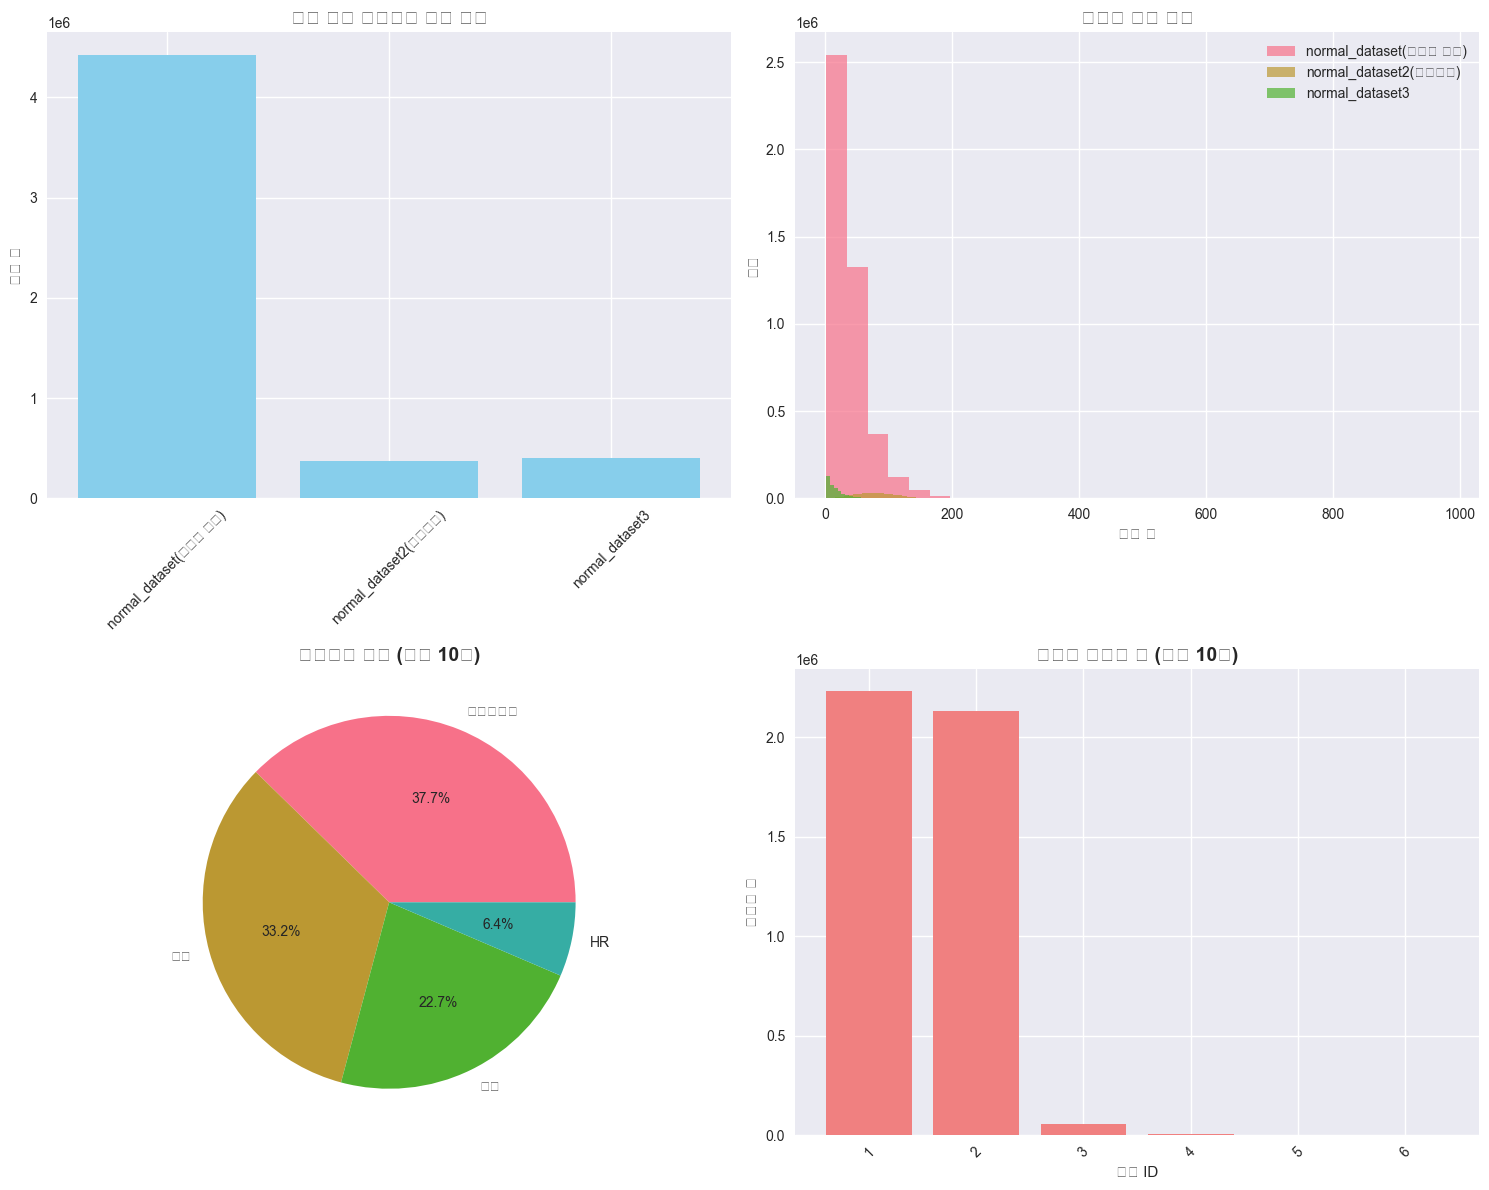

In [ ]:
# %%
# 시각화: 데이터셋 비교
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 데이터셋 크기 비교
dataset_sizes = [(name, len(df)) for name, df in cleaned_dataframes.items()]
names, sizes = zip(*dataset_sizes)

axes[0, 0].bar(names, sizes, color="skyblue")
axes[0, 0].set_title("일반 통화 데이터셋 크기 비교", fontsize=14, fontweight="bold")
axes[0, 0].set_ylabel("샘플 수")
axes[0, 0].tick_params(axis="x", rotation=45)

# 2. 텍스트 길이 분포
if any("msg" in df.columns for df in cleaned_dataframes.values()):
    for name, df in cleaned_dataframes.items():
        if "msg" in df.columns:
            text_lengths = df["msg"].str.len()
            axes[0, 1].hist(text_lengths, bins=30, alpha=0.7, label=name)

    axes[0, 1].set_title("텍스트 길이 분포", fontsize=14, fontweight="bold")
    axes[0, 1].set_xlabel("문자 수")
    axes[0, 1].set_ylabel("빈도")
    axes[0, 1].legend()

# 3. 카테고리 분포 (첫 번째 데이터셋 기준)
first_df = list(cleaned_dataframes.values())[0]
if "category" in first_df.columns:
    category_counts = first_df["category"].value_counts().head(10)
    axes[1, 0].pie(
        category_counts.values, labels=category_counts.index, autopct="%1.1f%%"
    )
    axes[1, 0].set_title("카테고리 분포 (상위 10개)", fontsize=14, fontweight="bold")

# 4. 화자 분포 (첫 번째 데이터셋 기준)
if "spk" in first_df.columns:
    speaker_counts = first_df["spk"].value_counts().head(10)
    axes[1, 1].bar(
        range(len(speaker_counts)), speaker_counts.values, color="lightcoral"
    )
    axes[1, 1].set_title("화자별 메시지 수 (상위 10명)", fontsize=14, fontweight="bold")
    axes[1, 1].set_xlabel("화자 ID")
    axes[1, 1].set_ylabel("메시지 수")
    axes[1, 1].set_xticks(range(len(speaker_counts)))
    axes[1, 1].set_xticklabels(speaker_counts.index, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# %%
# 5. 보이스 피싱 데이터와의 호환성을 위한 데이터 표준화
print("=== 데이터 표준화 시작 ===\n")

standardized_dataframes = {}

for name, df in cleaned_dataframes.items():
    print(f"📋 {name} 표준화 중...")

    # 표준 컬럼 정의 (보이스 피싱 데이터와 동일한 형식)
    standard_columns = {
        "file_name": "파일명",
        "category": "감정/상황 분류",
        "subcategory": "세부 분류",
        "spk": "화자 ID",
        "msg": "대화 내용",
    }

    # 표준화된 데이터프레임 생성
    std_df = pd.DataFrame()

    # 필수 컬럼 매핑 및 생성
    for std_col, description in standard_columns.items():
        if std_col in df.columns:
            std_df[std_col] = df[std_col]
        else:
            # 누락된 컬럼에 기본값 설정
            if std_col == "file_name":
                std_df[std_col] = f"{name}_file"
            elif std_col == "category":
                std_df[std_col] = "normal_call"  # 일반 통화로 라벨링
            elif std_col == "subcategory":
                std_df[std_col] = "general_conversation"
            elif std_col == "spk":
                std_df[std_col] = 1  # 기본 화자 ID
            elif std_col == "msg":
                # msg 컬럼이 없으면 다른 텍스트 컬럼 사용
                text_columns = [col for col in df.columns if df[col].dtype == "object"]
                if text_columns:
                    std_df[std_col] = df[text_columns[0]]
                else:
                    std_df[std_col] = ""

    # 추가 특성 컬럼들 보존
    feature_columns = [col for col in df.columns if col.startswith("text_")]
    for col in feature_columns:
        std_df[col] = df[col]

    # 데이터 타입 정리
    std_df["spk"] = pd.to_numeric(std_df["spk"], errors="coerce").fillna(1).astype(int)
    std_df["category"] = std_df["category"].astype(str)
    std_df["subcategory"] = std_df["subcategory"].astype(str)

    standardized_dataframes[name] = std_df
    print(f"   ✅ 표준화 완료 - 형태: {std_df.shape}")
    print(f"   📋 표준 컬럼: {list(std_df.columns)}")

=== 데이터 표준화 시작 ===

📋 normal_dataset(콜센터 상담) 표준화 중...
   ✅ 표준화 완료 - 형태: (4426586, 11)
   📋 표준 컬럼: ['file_name', 'category', 'subcategory', 'spk', 'msg', 'text_length', 'text_word_count', 'text_sentence_count', 'text_has_question', 'text_has_exclamation', 'text_has_number']
📋 normal_dataset2(감정분류) 표준화 중...
   ✅ 표준화 완료 - 형태: (377173, 11)
   📋 표준 컬럼: ['file_name', 'category', 'subcategory', 'spk', 'msg', 'text_length', 'text_word_count', 'text_sentence_count', 'text_has_question', 'text_has_exclamation', 'text_has_number']
📋 normal_dataset3 표준화 중...
   ✅ 표준화 완료 - 형태: (402387, 11)
   📋 표준 컬럼: ['file_name', 'category', 'subcategory', 'spk', 'msg', 'text_length', 'text_word_count', 'text_sentence_count', 'text_has_question', 'text_has_exclamation', 'text_has_number']


In [ ]:
# %%
# 표준화된 데이터 검증
print("=== 표준화된 데이터 검증 ===\n")

for name, df in standardized_dataframes.items():
    print(f"🔍 {name} 검증 결과:")

    # 필수 컬럼 존재 확인
    required_columns = ["file_name", "category", "subcategory", "spk", "msg"]
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"   ❌ 누락된 컬럼: {missing_columns}")
    else:
        print(f"   ✅ 모든 필수 컬럼 존재")

    # 데이터 품질 확인
    print(f"   📊 데이터 품질:")
    print(f"      - 총 샘플: {len(df):,}")
    print(f"      - 결측값: {df.isnull().sum().sum()}")
    print(f"      - 중복값: {df.duplicated().sum()}")

    # 카테고리 분포 확인
    if "category" in df.columns:
        print(f"      - 카테고리: {df['category'].value_counts().to_dict()}")

    # 텍스트 품질 확인
    if "msg" in df.columns:
        text_lengths = df["msg"].str.len()
        print(
            f"      - 텍스트 길이 (평균/중앙값): {text_lengths.mean():.1f}/{text_lengths.median():.1f}"
        )

    print()

=== 표준화된 데이터 검증 ===

🔍 normal_dataset(콜센터 상담) 검증 결과:
   ✅ 모든 필수 컬럼 존재
   📊 데이터 품질:
      - 총 샘플: 4,426,586
      - 결측값: 0
      - 중복값: 5
      - 카테고리: {'전자상거래': 1668072, '민원': 1467954, '교육': 1005854, 'HR': 284706}
      - 텍스트 길이 (평균/중앙값): 37.0/29.0

🔍 normal_dataset2(감정분류) 검증 결과:
   ✅ 모든 필수 컬럼 존재
   📊 데이터 품질:
      - 총 샘플: 377,173
      - 결측값: 0
      - 중복값: 0
      - 카테고리: {'분노': 76255, '기쁨': 73506, '불안': 57513, '슬픔': 57464, '당황': 56375, '상처': 56060}
      - 텍스트 길이 (평균/중앙값): 77.7/77.0

🔍 normal_dataset3 검증 결과:
   ✅ 모든 필수 컬럼 존재
   📊 데이터 품질:
      - 총 샘플: 402,387
      - 결측값: 0
      - 중복값: 28
      - 카테고리: {'실내': 344049, '실외': 58338}
      - 텍스트 길이 (평균/중앙값): 18.5/13.0



In [ ]:
# %%
# 6. 모델 학습을 위한 최종 데이터셋 구성
print("=== 최종 데이터셋 구성 ===\n")

if standardized_dataframes:
    # 모든 데이터프레임을 리스트로 변환
    all_dataframes = []

    for name, df in standardized_dataframes.items():
        df_copy = df.copy()
        df_copy["source_dataset"] = name  # 데이터 출처 표시
        df_copy["data_type"] = "normal_call"  # 일반 통화 데이터임을 표시
        all_dataframes.append(df_copy)

    # 데이터 통합
    final_dataset = pd.concat(all_dataframes, ignore_index=True)

    print(f"📈 최종 데이터셋 정보:")
    print(f"   - 총 샘플 수: {len(final_dataset):,}")
    print(f"   - 컬럼 수: {len(final_dataset.columns)}")
    print(
        f"   - 메모리 사용량: {final_dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB"
    )

    print(f"\n📋 컬럼 정보:")
    for col in final_dataset.columns:
        print(f"   - {col}: {final_dataset[col].dtype}")

    print(f"\n📊 데이터셋별 분포:")
    print(final_dataset["source_dataset"].value_counts())

    # 데이터 분할 제안
    print(f"\n🎯 모델 학습 데이터 분할 제안:")
    total_samples = len(final_dataset)
    train_size = int(total_samples * 0.8)
    val_size = int(total_samples * 0.1)
    test_size = total_samples - train_size - val_size

    print(f"   - 훈련 세트: {train_size:,} 샘플 (80%)")
    print(f"   - 검증 세트: {val_size:,} 샘플 (10%)")
    print(f"   - 테스트 세트: {test_size:,} 샘플 (10%)")

    # 보이스 피싱 데이터와 결합 준비
    print(f"\n🔗 보이스 피싱 데이터 결합 준비:")
    print(f"   - 현재 일반 통화 샘플: {len(final_dataset):,}")
    print(
        f"   - 보이스 피싱 데이터 추가 시 예상 총 샘플: {len(final_dataset) * 2:,} (1:1 비율 가정)"
    )

else:
    print("❌ 표준화된 데이터가 없습니다.")

=== 최종 데이터셋 구성 ===

📈 최종 데이터셋 정보:
   - 총 샘플 수: 5,206,146
   - 컬럼 수: 13
   - 메모리 사용량: 3766.93 MB

📋 컬럼 정보:
   - file_name: object
   - category: object
   - subcategory: object
   - spk: int64
   - msg: object
   - text_length: int64
   - text_word_count: int64
   - text_sentence_count: int64
   - text_has_question: bool
   - text_has_exclamation: bool
   - text_has_number: bool
   - source_dataset: object
   - data_type: object

📊 데이터셋별 분포:
source_dataset
normal_dataset(콜센터 상담)    4426586
normal_dataset3            402387
normal_dataset2(감정분류)      377173
Name: count, dtype: int64

🎯 모델 학습 데이터 분할 제안:
   - 훈련 세트: 4,164,916 샘플 (80%)
   - 검증 세트: 520,614 샘플 (10%)
   - 테스트 세트: 520,616 샘플 (10%)

🔗 보이스 피싱 데이터 결합 준비:
   - 현재 일반 통화 샘플: 5,206,146
   - 보이스 피싱 데이터 추가 시 예상 총 샘플: 10,412,292 (1:1 비율 가정)


In [ ]:
# %%
# 최종 데이터셋 저장
if "final_dataset" in locals():
    # 전처리된 일반 통화 데이터 저장
    output_path = Path("../../dataset")
    output_path.mkdir(exist_ok=True)

    # CSV 파일로 저장
    csv_output_path = output_path / "preprocessed_normal_calls.csv"
    final_dataset.to_csv(csv_output_path, index=False, encoding="utf-8-sig")
    print(f"✅ 전처리된 데이터 저장 완료: {csv_output_path}")

    # JSON 형태로도 저장 (메타데이터 포함)
    json_output_path = output_path / "preprocessed_normal_calls_metadata.json"
    metadata = {
        "total_samples": len(final_dataset),
        "columns": list(final_dataset.columns),
        "dataset_distribution": final_dataset["source_dataset"]
        .value_counts()
        .to_dict(),
        "category_distribution": (
            final_dataset["category"].value_counts().to_dict()
            if "category" in final_dataset.columns
            else {}
        ),
        "preprocessing_info": {
            "text_cleaning": "적용됨",
            "duplicate_removal": "적용됨",
            "standardization": "보이스 피싱 데이터와 호환되도록 표준화됨",
            "feature_extraction": "텍스트 특성 추출됨",
        },
    }

    with open(json_output_path, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False, indent=2)

    print(f"✅ 메타데이터 저장 완료: {json_output_path}")

    # 데이터 샘플 출력
    print(f"\n📄 데이터 샘플 (처음 5행):")
    print(final_dataset.head())

else:
    print("❌ 저장할 데이터가 없습니다.")

✅ 전처리된 데이터 저장 완료: ..\..\dataset\preprocessed_normal_calls.csv
✅ 메타데이터 저장 완료: ..\..\dataset\preprocessed_normal_calls_metadata.json

📄 데이터 샘플 (처음 5행):
      file_name category subcategory  spk  \
0  S000001.json       교육        공부방법    1   
1  S000001.json       교육        기타문의    1   
2  S000001.json       교육        기타문의    1   
3  S000001.json       교육        기타문의    2   
4  S000001.json       교육        기타문의    1   

                                              msg  text_length  \
0                     그 저기 뭐지 예 수학 선생님들이 여러분 계신데.           27   
1  n 네 그래요 그러면 얘한테 뭐 듣고 (싶) 우선은 (연) 연장 (가) 근데 여기가           46   
2                     조금 이런 게 안 좋은 것 (같아요)(같애요)l.           27   
3                        n 그 부분은 꼭 건의드리겠습니다. 어머니.           24   
4              n 네 좀 이런 부분은 조금 불편한 것 같네요 그러고 보니까.           34   

   text_word_count  text_sentence_count  text_has_question  \
0                8                    2              False   
1               14                    1              False

In [ ]:
# %%
# 7. 다음 단계 및 권장사항
print("=== 다음 단계 및 권장사항 ===\n")

print("🎯 현재 완료된 작업:")
print("✅ 일반 통화 데이터 로드 및 분석")
print("✅ 텍스트 전처리 및 정제")
print("✅ 데이터 표준화 (보이스 피싱 데이터와 호환)")
print("✅ 데이터 품질 검증")
print("✅ 최종 데이터셋 구성 및 저장")

print("\n🚀 다음 단계 권장사항:")
print("1. 📊 보이스 피싱 데이터 수집 및 전처리")
print("   - 보이스 피싱 텍스트 데이터 확보")
print("   - 동일한 형식으로 표준화")
print("   - 라벨링: category='voice_phishing'")

print("\n2. 🔗 데이터셋 결합")
print("   - 일반 통화 + 보이스 피싱 데이터 통합")
print("   - 클래스 균형 확인 및 조정")
print("   - 최종 학습 데이터셋 구성")

print("\n3. 🤖 모델 개발")
print("   - ML 모델: Random Forest, XGBoost, LightGBM")
print("   - DL 모델: BERT, RoBERTa, DistilBERT")
print("   - 텍스트 임베딩 및 특성 엔지니어링")

print("\n4. 🌐 웹 애플리케이션 개발")
print("   - Django 백엔드 구축")
print("   - 음성 파일 업로드 기능")
print("   - 실시간 보이스 피싱 판별")
print("   - LLM 기반 대응 방안 제시")

print("\n💡 추가 고려사항:")
print("• 데이터 증강: LLM을 활용한 보이스 피싱 데이터 생성")
print("• 모델 평가: 정확도, 재현율, F1-score 등 다양한 지표")
print("• 실시간 처리: 음성-텍스트 변환 및 즉시 판별")
print("• 사용자 경험: 직관적인 인터페이스 및 명확한 경고 메시지")

print("\n📈 예상 결과:")
print("• 보이스 피싱 탐지 정확도 향상")
print("• 실시간 위험 알림 시스템")
print("• 사용자 보안 의식 증진")
print("• 사회적 보안 강화에 기여")

print("\n🎉 일반 통화 데이터 전처리 완료!")

=== 다음 단계 및 권장사항 ===

🎯 현재 완료된 작업:
✅ 일반 통화 데이터 로드 및 분석
✅ 텍스트 전처리 및 정제
✅ 데이터 표준화 (보이스 피싱 데이터와 호환)
✅ 데이터 품질 검증
✅ 최종 데이터셋 구성 및 저장

🚀 다음 단계 권장사항:
1. 📊 보이스 피싱 데이터 수집 및 전처리
   - 보이스 피싱 텍스트 데이터 확보
   - 동일한 형식으로 표준화
   - 라벨링: category='voice_phishing'

2. 🔗 데이터셋 결합
   - 일반 통화 + 보이스 피싱 데이터 통합
   - 클래스 균형 확인 및 조정
   - 최종 학습 데이터셋 구성

3. 🤖 모델 개발
   - ML 모델: Random Forest, XGBoost, LightGBM
   - DL 모델: BERT, RoBERTa, DistilBERT
   - 텍스트 임베딩 및 특성 엔지니어링

4. 🌐 웹 애플리케이션 개발
   - Django 백엔드 구축
   - 음성 파일 업로드 기능
   - 실시간 보이스 피싱 판별
   - LLM 기반 대응 방안 제시

💡 추가 고려사항:
• 데이터 증강: LLM을 활용한 보이스 피싱 데이터 생성
• 모델 평가: 정확도, 재현율, F1-score 등 다양한 지표
• 실시간 처리: 음성-텍스트 변환 및 즉시 판별
• 사용자 경험: 직관적인 인터페이스 및 명확한 경고 메시지

📈 예상 결과:
• 보이스 피싱 탐지 정확도 향상
• 실시간 위험 알림 시스템
• 사용자 보안 의식 증진
• 사회적 보안 강화에 기여

🎉 일반 통화 데이터 전처리 완료!
